# Constructing Classification Models of Employment Status & Income Using Naive Bayes, Logistic Regression, and Random Forest

In [ ]:
import numpy as np
import pandas as pd
from sklearn import linear_model
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.pipeline import Pipeline
import matplotlib as mpl
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt

In [51]:
import warnings 

warnings.filterwarnings('ignore')

In [52]:
df1 = pd.read_csv('adult_data.txt', sep = ",", header = None)
df1.columns = ["Age", "WorkClass", "fnlwgt", "Education", "EducationNum",
                    "MaritalStatus", "Occupation", "Relationship", "Race", "Gender",
                    "CapitalGain", "CapitalLoss", "HoursPerWeek", "NativeCountry", "Income"]

print(df1.shape)
df1.head()

(32561, 15)


,Age,WorkClass,fnlwgt,Education,EducationNum,MaritalStatus,Occupation,Relationship,Race,Gender,CapitalGain,CapitalLoss,HoursPerWeek,NativeCountry,Income
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


# Exploring and Preprocessing

In [53]:
df1.isnull().sum(axis=0)

Age              0
WorkClass        0
fnlwgt           0
Education        0
EducationNum     0
MaritalStatus    0
Occupation       0
Relationship     0
Race             0
Gender           0
CapitalGain      0
CapitalLoss      0
HoursPerWeek     0
NativeCountry    0
Income           0
dtype: int64

In [54]:
df1.dtypes

Age               int64
WorkClass        object
fnlwgt            int64
Education        object
EducationNum      int64
MaritalStatus    object
Occupation       object
Relationship     object
Race             object
Gender           object
CapitalGain       int64
CapitalLoss       int64
HoursPerWeek      int64
NativeCountry    object
Income           object
dtype: object

In [55]:
df1.nunique()

Age                 73
WorkClass            9
fnlwgt           21648
Education           16
EducationNum        16
MaritalStatus        7
Occupation          15
Relationship         6
Race                 5
Gender               2
CapitalGain        119
CapitalLoss         92
HoursPerWeek        94
NativeCountry       42
Income               2
dtype: int64

In [56]:
df1.head()

,Age,WorkClass,fnlwgt,Education,EducationNum,MaritalStatus,Occupation,Relationship,Race,Gender,CapitalGain,CapitalLoss,HoursPerWeek,NativeCountry,Income
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


In [57]:
#EducationNum omitted because it is a numeric (but equally categorical) version of Education
df1_bern = df1[['WorkClass','Education','MaritalStatus','Occupation',
                'Relationship','Race','Gender','NativeCountry','Income']]

df1_bern.head()

,WorkClass,Education,MaritalStatus,Occupation,Relationship,Race,Gender,NativeCountry,Income
0,State-gov,Bachelors,Never-married,Adm-clerical,Not-in-family,White,Male,United-States,<=50K
1,Self-emp-not-inc,Bachelors,Married-civ-spouse,Exec-managerial,Husband,White,Male,United-States,<=50K
2,Private,HS-grad,Divorced,Handlers-cleaners,Not-in-family,White,Male,United-States,<=50K
3,Private,11th,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,United-States,<=50K
4,Private,Bachelors,Married-civ-spouse,Prof-specialty,Wife,Black,Female,Cuba,<=50K


### Out of sheer, potentially fruitless curiosity, I'm going to try fitting the Bernoulli classifier once with numerical columns and once using its binarize parameter. So, I will preprocess & analyze the data twice in order to fairly compare the results. 

In [58]:
df1_bern2 = df1.drop(['EducationNum'],axis=1)
df1_bern2.head()

,Age,WorkClass,fnlwgt,Education,MaritalStatus,Occupation,Relationship,Race,Gender,CapitalGain,CapitalLoss,HoursPerWeek,NativeCountry,Income
0,39,State-gov,77516,Bachelors,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


### Since Bernoulli Naive Bayes requires that features be binary, all features with more than two response levels will be One-Hot encoded. 'Gender' and 'Income' will be encoded using LabelEncoder.

In [59]:
le = LabelEncoder()
df1_bern['Gender'] = le.fit_transform(df1_bern['Gender'])
df1_bern['Income'] = le.fit_transform(df1_bern['Income'])
onehot_Education = pd.get_dummies(df1_bern['Education'], prefix='Educ')
onehot_Marital = pd.get_dummies(df1_bern['MaritalStatus'], prefix='MarStat')
onehot_Occupation = pd.get_dummies(df1_bern['Occupation'], prefix='Occup')
onehot_Relationship = pd.get_dummies(df1_bern['Relationship'], prefix='Relat')
onehot_Race = pd.get_dummies(df1_bern['Race'], prefix='Race')
onehot_NCountry = pd.get_dummies(df1_bern['NativeCountry'], prefix='NCountry')

df1_bern2['Gender'] = le.fit_transform(df1_bern2['Gender'])
df1_bern2['Income'] = le.fit_transform(df1_bern2['Income'])
onehot_Education = pd.get_dummies(df1_bern2['Education'], prefix='Educ')
onehot_Marital = pd.get_dummies(df1_bern2['MaritalStatus'], prefix='MarStat')
onehot_Occupation = pd.get_dummies(df1_bern2['Occupation'], prefix='Occup')
onehot_Relationship = pd.get_dummies(df1_bern2['Relationship'], prefix='Relat')
onehot_Race = pd.get_dummies(df1_bern2['Race'], prefix='Race')
onehot_NCountry = pd.get_dummies(df1_bern2['NativeCountry'], prefix='NCountry')

In [60]:
# Concatenating one-hot encoded features with DataFrame.
df1_bern = pd.concat([df1_bern, onehot_Education], axis=1)
df1_bern = pd.concat([df1_bern, onehot_Marital], axis=1)
df1_bern = pd.concat([df1_bern, onehot_Occupation], axis=1)
df1_bern = pd.concat([df1_bern, onehot_Relationship], axis=1)
df1_bern = pd.concat([df1_bern, onehot_Race], axis=1)
df1_bern = pd.concat([df1_bern, onehot_NCountry], axis=1)

df1_bern2 = pd.concat([df1_bern2, onehot_Education], axis=1)
df1_bern2 = pd.concat([df1_bern2, onehot_Marital], axis=1)
df1_bern2 = pd.concat([df1_bern2, onehot_Occupation], axis=1)
df1_bern2 = pd.concat([df1_bern2, onehot_Relationship], axis=1)
df1_bern2 = pd.concat([df1_bern2, onehot_Race], axis=1)
df1_bern2 = pd.concat([df1_bern2, onehot_NCountry], axis=1)

In [61]:
df1_bern.head()

,WorkClass,Education,MaritalStatus,Occupation,Relationship,Race,Gender,NativeCountry,Income,Educ_ 10th,...,NCountry_ Portugal,NCountry_ Puerto-Rico,NCountry_ Scotland,NCountry_ South,NCountry_ Taiwan,NCountry_ Thailand,NCountry_ Trinadad&Tobago,NCountry_ United-States,NCountry_ Vietnam,NCountry_ Yugoslavia
0,State-gov,Bachelors,Never-married,Adm-clerical,Not-in-family,White,1,United-States,0,0,...,0,0,0,0,0,0,0,1,0,0
1,Self-emp-not-inc,Bachelors,Married-civ-spouse,Exec-managerial,Husband,White,1,United-States,0,0,...,0,0,0,0,0,0,0,1,0,0
2,Private,HS-grad,Divorced,Handlers-cleaners,Not-in-family,White,1,United-States,0,0,...,0,0,0,0,0,0,0,1,0,0
3,Private,11th,Married-civ-spouse,Handlers-cleaners,Husband,Black,1,United-States,0,0,...,0,0,0,0,0,0,0,1,0,0
4,Private,Bachelors,Married-civ-spouse,Prof-specialty,Wife,Black,0,Cuba,0,0,...,0,0,0,0,0,0,0,0,0,0


In [62]:
df1_bern2.head()

,Age,WorkClass,fnlwgt,Education,MaritalStatus,Occupation,Relationship,Race,Gender,CapitalGain,...,NCountry_ Portugal,NCountry_ Puerto-Rico,NCountry_ Scotland,NCountry_ South,NCountry_ Taiwan,NCountry_ Thailand,NCountry_ Trinadad&Tobago,NCountry_ United-States,NCountry_ Vietnam,NCountry_ Yugoslavia
0,39,State-gov,77516,Bachelors,Never-married,Adm-clerical,Not-in-family,White,1,2174,...,0,0,0,0,0,0,0,1,0,0
1,50,Self-emp-not-inc,83311,Bachelors,Married-civ-spouse,Exec-managerial,Husband,White,1,0,...,0,0,0,0,0,0,0,1,0,0
2,38,Private,215646,HS-grad,Divorced,Handlers-cleaners,Not-in-family,White,1,0,...,0,0,0,0,0,0,0,1,0,0
3,53,Private,234721,11th,Married-civ-spouse,Handlers-cleaners,Husband,Black,1,0,...,0,0,0,0,0,0,0,1,0,0
4,28,Private,338409,Bachelors,Married-civ-spouse,Prof-specialty,Wife,Black,0,0,...,0,0,0,0,0,0,0,0,0,0


In [63]:
#Dropping the columns that were encoded
df1_bern = df1_bern.drop(['Education','MaritalStatus','Occupation',
                               'Relationship','Race','NativeCountry'], axis = 1)

df1_bern2 = df1_bern2.drop(['Education','MaritalStatus','Occupation',
                               'Relationship','Race','NativeCountry'], axis = 1)

In [64]:
df1_bern.head()

,WorkClass,Gender,Income,Educ_ 10th,Educ_ 11th,Educ_ 12th,Educ_ 1st-4th,Educ_ 5th-6th,Educ_ 7th-8th,Educ_ 9th,...,NCountry_ Portugal,NCountry_ Puerto-Rico,NCountry_ Scotland,NCountry_ South,NCountry_ Taiwan,NCountry_ Thailand,NCountry_ Trinadad&Tobago,NCountry_ United-States,NCountry_ Vietnam,NCountry_ Yugoslavia
0,State-gov,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
1,Self-emp-not-inc,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
2,Private,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,Private,1,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
4,Private,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [65]:
df1_bern2.head()

,Age,WorkClass,fnlwgt,Gender,CapitalGain,CapitalLoss,HoursPerWeek,Income,Educ_ 10th,Educ_ 11th,...,NCountry_ Portugal,NCountry_ Puerto-Rico,NCountry_ Scotland,NCountry_ South,NCountry_ Taiwan,NCountry_ Thailand,NCountry_ Trinadad&Tobago,NCountry_ United-States,NCountry_ Vietnam,NCountry_ Yugoslavia
0,39,State-gov,77516,1,2174,0,40,0,0,0,...,0,0,0,0,0,0,0,1,0,0
1,50,Self-emp-not-inc,83311,1,0,0,13,0,0,0,...,0,0,0,0,0,0,0,1,0,0
2,38,Private,215646,1,0,0,40,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,53,Private,234721,1,0,0,40,0,0,1,...,0,0,0,0,0,0,0,1,0,0
4,28,Private,338409,0,0,0,40,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## Checking for violation(s) of the assumption of normality using qqplots

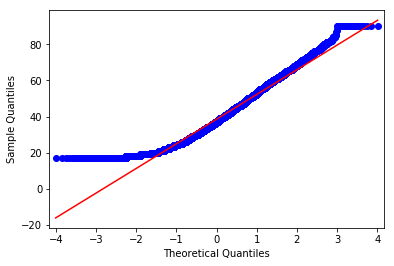

In [66]:
from statsmodels.graphics.gofplots import qqplot
from matplotlib import pyplot
qqplot((df1_bern2['Age']), line='s')
pyplot.show()

### Eh...Unideal. I'll apply a log transformation. 

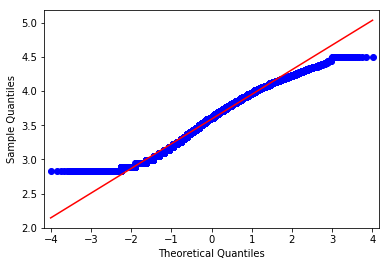

In [67]:
qqplot((df1_bern2['Age'].apply(np.log)), line='s')
pyplot.show()

### Looking much better.

In [68]:
df1_bern2[['Age']] = df1_bern2[['Age']].apply(np.log)

## Checking 'fnlwgt'

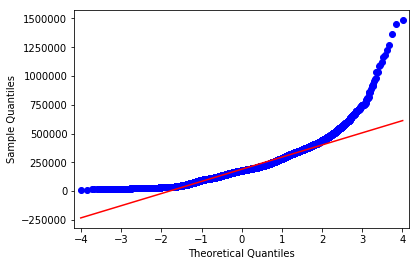

In [69]:
qqplot((df1_bern2['fnlwgt']), line='s')
pyplot.show()

### ...Even less ideal. No problem, though! Let's make with the transforming.

In [70]:
from numpy import exp
df1_bern2['fnlwgt'] = df1_bern2['fnlwgt']**4

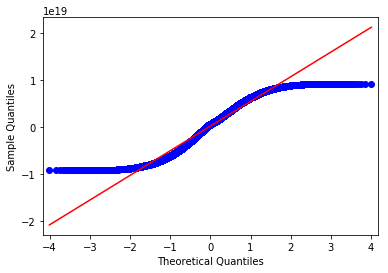

In [71]:
qqplot((df1_bern2['fnlwgt']), line='s')
pyplot.show()

### Very nice.

## Checking 'CapitalGain'

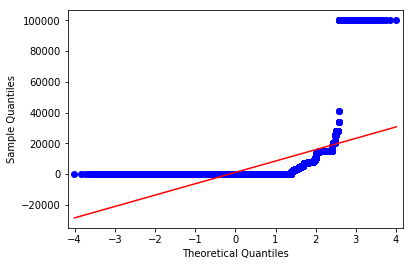

In [72]:
qqplot((df1_bern2['CapitalGain']), line='s')
pyplot.show()

## Uh oh! OK, no problem, we'll fix that right up!

In [73]:
#inverse hyperbolic sine
arc = np.arcsinh(df1_bern2[['CapitalGain']])

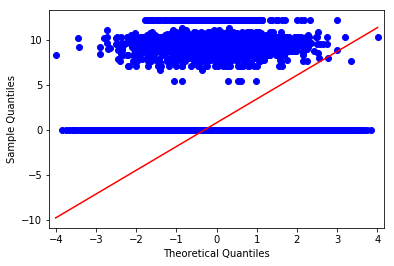

In [74]:
qqplot(arc, line='s')
pyplot.show()

## Oh God.

### Alright. I attempted to transform this data using square root, exponent, and log to no/little avail. So, I have decided to convert CapitalGain into an ordinal variable. This will help deal with the immense number of zeroes and values at the "ceiling" of the distribution (i.e. values of 100,000). Essentially, the responses seem to fall into one of three groups: 1) CapitalGains = 0; 2) CapitalGains = 1-50000; CapitalGains = 100,000. Although converting CapitalGain to an ordinal feature will result in a loss of information, it is better to avoid introducing bias.

In [75]:
bins = [-1, 1, 50000, 100000]
labels = [1,2,3]
df1_bern2['CapitalGain'] = pd.cut(df1_bern2['CapitalGain'], bins=bins, labels=labels)

In [76]:
df1_bern2.head()


,Age,WorkClass,fnlwgt,Gender,CapitalGain,CapitalLoss,HoursPerWeek,Income,Educ_ 10th,Educ_ 11th,...,NCountry_ Portugal,NCountry_ Puerto-Rico,NCountry_ Scotland,NCountry_ South,NCountry_ Taiwan,NCountry_ Thailand,NCountry_ Trinadad&Tobago,NCountry_ United-States,NCountry_ Vietnam,NCountry_ Yugoslavia
0,3.663562,State-gov,-788648858049277696,1,2,0,40,0,0,0,...,0,0,0,0,0,0,0,1,0,0
1,3.912023,Self-emp-not-inc,-7166600331323011007,1,1,0,13,0,0,0,...,0,0,0,0,0,0,0,1,0,0
2,3.637586,Private,4278303986812064784,1,1,0,40,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,3.970292,Private,-8369683455247455359,1,1,0,40,0,0,1,...,0,0,0,0,0,0,0,1,0,0
4,3.332205,Private,-655466583084258015,0,1,0,40,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [77]:
onehot_CapitalGain = pd.get_dummies(df1_bern2['CapitalGain'], prefix='Cap_Gain')
df1_bern2 = pd.concat([df1_bern2, onehot_CapitalGain], axis=1)
df1_bern2 = df1_bern2.drop(['CapitalGain'],axis=1)
df1_bern2.head()

,Age,WorkClass,fnlwgt,Gender,CapitalLoss,HoursPerWeek,Income,Educ_ 10th,Educ_ 11th,Educ_ 12th,...,NCountry_ South,NCountry_ Taiwan,NCountry_ Thailand,NCountry_ Trinadad&Tobago,NCountry_ United-States,NCountry_ Vietnam,NCountry_ Yugoslavia,Cap_Gain_1,Cap_Gain_2,Cap_Gain_3
0,3.663562,State-gov,-788648858049277696,1,0,40,0,0,0,0,...,0,0,0,0,1,0,0,0,1,0
1,3.912023,Self-emp-not-inc,-7166600331323011007,1,0,13,0,0,0,0,...,0,0,0,0,1,0,0,1,0,0
2,3.637586,Private,4278303986812064784,1,0,40,0,0,0,0,...,0,0,0,0,1,0,0,1,0,0
3,3.970292,Private,-8369683455247455359,1,0,40,0,0,1,0,...,0,0,0,0,1,0,0,1,0,0
4,3.332205,Private,-655466583084258015,0,0,40,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


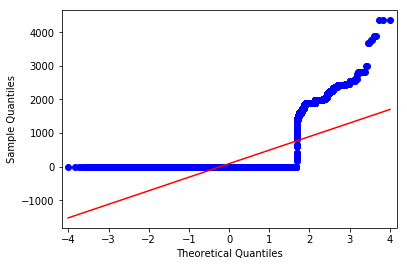

In [78]:
qqplot((df1_bern2['CapitalLoss']), line='s')
pyplot.show()

In [79]:
bins = [-1, 1, 1500, 3000, 4500]
labels = [1,2,3,4]
df1_bern2['CapitalLoss'] = pd.cut(df1_bern2['CapitalLoss'], bins=bins, labels=labels)

In [80]:
onehot_CapitalLoss = pd.get_dummies(df1_bern2['CapitalLoss'], prefix='Cap_Loss')
df1_bern2 = pd.concat([df1_bern2, onehot_CapitalLoss], axis=1)
df1_bern2 = df1_bern2.drop(['CapitalLoss'],axis=1)
df1_bern2.head()

,Age,WorkClass,fnlwgt,Gender,HoursPerWeek,Income,Educ_ 10th,Educ_ 11th,Educ_ 12th,Educ_ 1st-4th,...,NCountry_ United-States,NCountry_ Vietnam,NCountry_ Yugoslavia,Cap_Gain_1,Cap_Gain_2,Cap_Gain_3,Cap_Loss_1,Cap_Loss_2,Cap_Loss_3,Cap_Loss_4
0,3.663562,State-gov,-788648858049277696,1,40,0,0,0,0,0,...,1,0,0,0,1,0,1,0,0,0
1,3.912023,Self-emp-not-inc,-7166600331323011007,1,13,0,0,0,0,0,...,1,0,0,1,0,0,1,0,0,0
2,3.637586,Private,4278303986812064784,1,40,0,0,0,0,0,...,1,0,0,1,0,0,1,0,0,0
3,3.970292,Private,-8369683455247455359,1,40,0,0,1,0,0,...,1,0,0,1,0,0,1,0,0,0
4,3.332205,Private,-655466583084258015,0,40,0,0,0,0,0,...,0,0,0,1,0,0,1,0,0,0


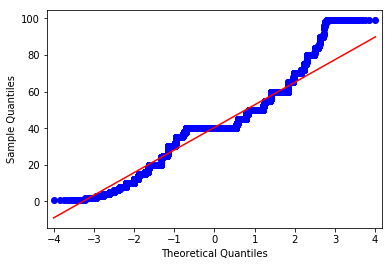

In [81]:
qqplot((df1_bern2['HoursPerWeek']), line='s')
pyplot.show()

### Creating variables for features and target

In [82]:
bern_features = df1_bern.drop(['WorkClass'],axis=1)
bern_target = df1_bern[['WorkClass']]

bern_features2 = df1_bern2.drop(['WorkClass'],axis=1)
bern_target2 = df1_bern2[['WorkClass']]

### Splitting into test/train

In [83]:
X_train, X_test, y_train, y_test = train_test_split(bern_features, 
                                                    bern_target, 
                                                    test_size=0.2, 
                                                    random_state=1)

X_train2, X_test2, y_train2, y_test2 = train_test_split(bern_features2, 
                                                    bern_target2, 
                                                    test_size=0.2, 
                                                    random_state=1)

### Scaling continuous variables

In [96]:
scaler = StandardScaler()

X_train2[['Age','fnlwgt','HoursPerWeek']] = scaler.fit_transform(X_train2[['Age','fnlwgt','HoursPerWeek']])

X_test2[['Age','fnlwgt','HoursPerWeek']] = scaler.transform(X_test2[['Age','fnlwgt','HoursPerWeek']])

### Computing class priors for Bernoulli Naive Bayes

In [97]:
print('P(Private) = ',22696/32561)
print('P(Self-Emp: NI) = ',2541/32561)
print('P(Local Gov) = ',2093/32561)
print('P(?) = ',1836/32561)
print('P(State Gov) = ',1298/32561)
print('P(Self-Emp: I) = ',1116/32561)
print('P(Fed Gov) = ',960/32561)
print('P(W/O Pay) = ',14/32561)
print('P(Never Emp) = ',7/32561)

P(Private) =  0.6970301894904948
P(Self-Emp: NI) =  0.0780381437916526
P(Local Gov) =  0.06427935259973588
P(?) =  0.05638647461687295
P(State Gov) =  0.039863640551580114
P(Self-Emp: I) =  0.034274131629863945
P(Fed Gov) =  0.029483123982678664
P(W/O Pay) =  0.00042996222474739717
P(Never Emp) =  0.00021498111237369858


In [98]:
from sklearn.naive_bayes import BernoulliNB
bern = BernoulliNB(class_prior=[0.697, 0.078, 0.064, 
                                0.056, 0.04, 0.034,
                                0.029, 0.001, 0.001])

In [99]:
bern2 = BernoulliNB(class_prior=[0.697, 0.078, 0.064,
                                 0.056, 0.04, 0.034,
                                 0.029, 0.001, 0.001], binarize=0.5)

# Constructing Bernoulli naive Bayes classifier

In [100]:
bern_model = bern.fit(X_train, y_train)

bern_model2 = bern2.fit(X_train2, y_train2)

In [103]:
prob_train = bern_model.predict_proba(X_train)

prob_train2 = bern_model2.predict_proba(X_train2)

In [104]:
y_predict_train = y_train
y_predict_train['class_pred'] = bern_model.predict(X_train)

y_predict_test = y_test
y_predict_test['class_pred'] = bern_model.predict(X_test)

y_predict_train2 = y_train2
y_predict_train2['class_pred'] = bern_model2.predict(X_train2)

y_predict_test2 = y_test2
y_predict_test2['class_pred'] = bern_model2.predict(X_test2)

### Confusion matrix for NB model on training data

In [106]:
pd.crosstab(y_predict_train['WorkClass'], y_predict_train['class_pred'],
            rownames=['True'], colnames=['Predicted'], margins=True)

Predicted,?,Federal-gov,Local-gov,Never-worked,Private,Self-emp-inc,Self-emp-not-inc,Without-pay,All
True,,,,,,,,,
?,1467,0,0,0,0,0,0,0,1467
Federal-gov,0,406,126,0,71,125,39,0,767
Local-gov,0,341,837,0,187,173,148,0,1686
Never-worked,6,0,0,0,0,0,0,0,6
Private,0,3744,2115,26,7171,3043,2008,4,18111
Self-emp-inc,0,100,61,0,122,526,97,0,906
Self-emp-not-inc,0,204,223,0,392,585,641,0,2045
State-gov,0,307,370,0,134,176,63,0,1050
Without-pay,0,1,0,0,5,0,4,0,10


In [107]:
pd.crosstab(y_predict_train2['WorkClass'], y_predict_train2['class_pred'],
            rownames=['True'], colnames=['Predicted'], margins=True)

Predicted,?,Federal-gov,Local-gov,Never-worked,Private,Self-emp-inc,Self-emp-not-inc,Without-pay,All
True,,,,,,,,,
?,1467,0,0,0,0,0,0,0,1467
Federal-gov,0,405,125,0,70,123,44,0,767
Local-gov,0,340,810,0,194,201,141,0,1686
Never-worked,6,0,0,0,0,0,0,0,6
Private,0,3519,2066,20,7508,2904,2091,3,18111
Self-emp-inc,0,86,50,0,119,546,105,0,906
Self-emp-not-inc,0,191,218,0,371,614,651,0,2045
State-gov,0,296,355,0,156,181,62,0,1050
Without-pay,0,1,0,0,5,0,4,0,10


### Probability estimates for training data

In [108]:
bnb_train = pd.DataFrame(bern_model.predict_proba(X_train))
bnb_train.columns = ['prob' + str(col) for col in bnb_train.columns]
bnb_train.head()

,prob0,prob1,prob2,prob3,prob4,prob5,prob6,prob7,prob8
0,4.599047e-05,0.048526,0.178128,8.921797e-07,0.207614,0.152726,0.412215,0.000713,3.100626e-05
1,7.312827e-08,0.072393,0.020442,5.253422e-10,0.005641,0.855702,0.045498,0.000324,1.232250e-08
2,3.909276e-07,0.009889,0.001246,1.768443e-09,0.025496,0.778030,0.185309,0.000028,5.866575e-07
3,5.301537e-04,0.157640,0.121178,2.074327e-05,0.294713,0.026214,0.395923,0.003758,2.270404e-05
4,1.466682e-04,0.331759,0.269135,7.423243e-05,0.366309,0.005006,0.026591,0.000715,2.654144e-04


In [109]:
bnb_train2 = pd.DataFrame(bern_model2.predict_proba(X_train2))
bnb_train2.columns = ['prob' + str(col) for col in bnb_train2.columns]
bnb_train2.head()

,prob0,prob1,prob2,prob3,prob4,prob5,prob6,prob7,prob8
0,7.335508e-05,0.059520,0.216539,9.509723e-07,0.342605,0.061676,0.318505,0.001069,1.245052e-05
1,1.371405e-07,0.135080,0.033296,1.346967e-10,0.006336,0.765922,0.058906,0.000460,8.331714e-09
2,1.673448e-08,0.002367,0.000507,2.050675e-09,0.006351,0.849852,0.140917,0.000005,4.324269e-07
3,1.646207e-04,0.096100,0.085506,1.329367e-06,0.141231,0.049864,0.625431,0.001688,1.342950e-05
4,1.822462e-04,0.410165,0.290461,1.261103e-05,0.272608,0.002969,0.022811,0.000673,1.189056e-04


### Probabillity estimates for test data

In [110]:
bnb_test = pd.DataFrame(bern_model.predict_proba(X_test))
bnb_test.columns = ['prob' + str(col) for col in bnb_test.columns]
bnb_test.head()

,prob0,prob1,prob2,prob3,prob4,prob5,prob6,prob7,prob8
0,0.000670,0.011610,0.502806,1.680120e-05,0.392901,0.002228,0.086995,0.002764,0.000009
1,0.000261,0.020559,0.129166,3.147106e-04,0.813913,0.000930,0.033572,0.001206,0.000079
2,0.000171,0.134590,0.200036,1.267972e-04,0.269971,0.116763,0.274964,0.003290,0.000088
3,0.000003,0.148460,0.244926,9.537879e-09,0.052701,0.224435,0.326957,0.002513,0.000005
4,0.000696,0.028686,0.035342,1.755320e-04,0.930680,0.000304,0.003534,0.000567,0.000015


In [111]:
bnb_df2 = pd.DataFrame(bern_model2.predict_proba(X_test2))
bnb_df2.columns = ['prob' + str(col) for col in bnb_df2.columns]
bnb_df2.head()

,prob0,prob1,prob2,prob3,prob4,prob5,prob6,prob7,prob8
0,0.000300,0.010209,0.511765,1.553118e-06,0.271588,0.006113,0.198224,0.001791,0.000007
1,0.000268,0.016224,0.101025,2.158254e-04,0.864153,0.000242,0.016690,0.001162,0.000020
2,0.000024,0.069373,0.101136,6.959580e-05,0.126191,0.392332,0.308957,0.001569,0.000348
3,0.000005,0.175563,0.321372,1.312124e-08,0.100085,0.111841,0.286718,0.004413,0.000003
4,0.000716,0.018301,0.025018,1.302776e-04,0.953537,0.000082,0.001672,0.000538,0.000005


## Metrics! Everyone loves metrics! Let's see how we did.

In [112]:
#Accuracy for training set (using binarize)...Not too great! D:
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

accuracy_score(y_predict_train['WorkClass'], y_predict_train['class_pred'])

0.42414004914004916

In [113]:
#Accuracy for test set (using binarize)...Also not too great!
accuracy_score(y_predict_test['WorkClass'], y_predict_test['class_pred'])

0.4177798249654537

In [114]:
# Accuracy for training set (not using binarize)... Also not too great!
accuracy_score(y_predict_train2['WorkClass'], y_predict_train2['class_pred'])

0.43715448402948404

In [115]:
# Accuracy for test set (not using binarize)... Also not too great!
accuracy_score(y_predict_test2['WorkClass'], y_predict_test2['class_pred'])

0.428681099339782

## Well, the results were somewhat disappointing! It seems that using the binarize parameter did not have a significant impact on model performance in this case. In the future, I would like to figure out how much 'CapitalGain' and 'CapitalLoss' respectively impacted the model's accuracy. 

## Let's quickly make sure that the distribution of the train and test sets are approximately equal prior to moving onto building a Logistic Regression model.

In [116]:
y_train['WorkClass'].value_counts()

 Private             18111
 Self-emp-not-inc     2045
 Local-gov            1686
 ?                    1467
 State-gov            1050
 Self-emp-inc          906
 Federal-gov           767
 Without-pay            10
 Never-worked            6
Name: WorkClass, dtype: int64

In [117]:
print(18111/26048)
print(2045/26048)
print(1686/26048)
print(1467/26048)
print(1050/26048)
print(906/26048)
print(767/26048)
print(10/26048)
print(6/26048)

0.6952933046683046
0.07850890663390664
0.06472665847665848
0.056319103194103194
0.04031019656019656
0.03478194103194103
0.02944563882063882
0.0003839066339066339
0.00023034398034398035


In [118]:
y_test['WorkClass'].value_counts()

 Private             4585
 Self-emp-not-inc     496
 Local-gov            407
 ?                    369
 State-gov            248
 Self-emp-inc         210
 Federal-gov          193
 Without-pay            4
 Never-worked           1
Name: WorkClass, dtype: int64

In [119]:
print(4585/6513)
print(496/6513)
print(407/6513)
print(369/6513)
print(248/6513)
print(210/6513)
print(193/6513)
print(4/6513)
print(1/6513)

0.7039766620604944
0.0761553815446031
0.062490403807769074
0.05665591893136803
0.03807769077230155
0.032243205895900504
0.029633041609089514
0.0006141563027790573
0.00015353907569476432


# Logistic Regression

In [120]:
MLR_X_TRAIN = X_train2
MLR_Y_TRAIN = y_train2
MLR_X_TEST = X_test2
MLR_Y_TEST = y_test2
MLR_X_TRAIN.head()

,Age,fnlwgt,Gender,HoursPerWeek,Income,Educ_ 10th,Educ_ 11th,Educ_ 12th,Educ_ 1st-4th,Educ_ 5th-6th,...,NCountry_ United-States,NCountry_ Vietnam,NCountry_ Yugoslavia,Cap_Gain_1,Cap_Gain_2,Cap_Gain_3,Cap_Loss_1,Cap_Loss_2,Cap_Loss_3,Cap_Loss_4
16465,0.206620,-1.642741,1,-0.034534,0,0,1,0,0,0,...,1,0,0,1,0,0,1,0,0,0
5625,1.109869,-1.479970,1,-0.034534,1,0,0,0,0,0,...,1,0,0,1,0,0,1,0,0,0
30273,-0.342469,1.686064,1,0.776074,1,0,0,0,0,0,...,1,0,0,1,0,0,0,0,1,0
3136,0.603813,0.165223,1,0.776074,0,0,0,0,0,0,...,1,0,0,1,0,0,1,0,0,0
4521,1.402309,0.276262,1,-0.034534,0,1,0,0,0,0,...,1,0,0,1,0,0,1,0,0,0


In [121]:
MLR_Y_TEST.head()

,WorkClass,class_pred
9646,Self-emp-not-inc,Local-gov
709,Private,Private
7385,Private,Self-emp-inc
16671,Private,Local-gov
21932,Private,Private


In [122]:
MLR_Y_TRAIN = MLR_Y_TRAIN.drop(MLR_Y_TRAIN[['class_pred']],axis=1)
MLR_Y_TEST = MLR_Y_TEST.drop(MLR_Y_TEST[['class_pred']],axis=1)

In [123]:
MLR_X_TRAIN.head()

,Age,fnlwgt,Gender,HoursPerWeek,Income,Educ_ 10th,Educ_ 11th,Educ_ 12th,Educ_ 1st-4th,Educ_ 5th-6th,...,NCountry_ United-States,NCountry_ Vietnam,NCountry_ Yugoslavia,Cap_Gain_1,Cap_Gain_2,Cap_Gain_3,Cap_Loss_1,Cap_Loss_2,Cap_Loss_3,Cap_Loss_4
16465,0.206620,-1.642741,1,-0.034534,0,0,1,0,0,0,...,1,0,0,1,0,0,1,0,0,0
5625,1.109869,-1.479970,1,-0.034534,1,0,0,0,0,0,...,1,0,0,1,0,0,1,0,0,0
30273,-0.342469,1.686064,1,0.776074,1,0,0,0,0,0,...,1,0,0,1,0,0,0,0,1,0
3136,0.603813,0.165223,1,0.776074,0,0,0,0,0,0,...,1,0,0,1,0,0,1,0,0,0
4521,1.402309,0.276262,1,-0.034534,0,1,0,0,0,0,...,1,0,0,1,0,0,1,0,0,0


In [124]:
MLR_Y_TEST.head()

,WorkClass
9646,Self-emp-not-inc
709,Private
7385,Private
16671,Private
21932,Private


In [125]:
from sklearn.linear_model import LogisticRegression
MLR = LogisticRegression(random_state=0, 
                         multi_class='multinomial', 
                         solver='newton-cg', 
                         penalty = 'l2',
                         C = 5, 
                         max_iter = 100)

### Constructing LR Model

In [126]:
MLRM = MLR.fit(MLR_X_TRAIN, MLR_Y_TRAIN)

In [127]:
y_test_mlr = MLR_Y_TEST

In [128]:
# Class predictions for training data
MLR_Y_TRAIN['MLR_PRED'] = MLRM.predict(MLR_X_TRAIN)

In [129]:
#Accuracy score of model on training data
accuracy_score(MLR_Y_TRAIN['WorkClass'], MLR_Y_TRAIN['MLR_PRED'])

0.7630912162162162

In [130]:
#Class predictions for test data
MLR_Y_TEST['MLR_PRED'] = MLRM.predict(MLR_X_TEST)

In [131]:
#Accuracy score of model on test data
accuracy_score(MLR_Y_TEST['WorkClass'], MLR_Y_TEST['MLR_PRED'])

0.7690772301550745

In [132]:
pd.crosstab(MLR_Y_TEST['WorkClass'], MLR_Y_TEST['MLR_PRED'],
            rownames=['True'], colnames=['Predicted'], margins=True)

Predicted,?,Federal-gov,Local-gov,Private,Self-emp-inc,Self-emp-not-inc,State-gov,All
True,,,,,,,,
?,369,0,0,0,0,0,0,369
Federal-gov,0,3,6,182,1,0,1,193
Local-gov,0,1,65,337,0,2,2,407
Never-worked,1,0,0,0,0,0,0,1
Private,0,0,36,4495,5,48,1,4585
Self-emp-inc,0,0,4,191,6,9,0,210
Self-emp-not-inc,0,0,4,418,3,71,0,496
State-gov,0,0,26,217,1,4,0,248
Without-pay,0,0,0,2,0,2,0,4


## Let's use AUC-ROC curves to evaluate the performance of the model!

### To do so, I will first need to compute probability estimates...

In [133]:
mlr_df = pd.DataFrame(MLRM.predict_proba(MLR_X_TEST))
mlr_df.columns = ['prob' + str(col) for col in mlr_df.columns]
mlr_df.head()

,prob0,prob1,prob2,prob3,prob4,prob5,prob6,prob7,prob8
0,0.000117,0.000565,0.069114,4.461873e-08,0.706507,0.032474,0.180584,0.010638,4.882936e-07
1,0.000029,0.002792,0.020884,5.332276e-05,0.942111,0.001152,0.021664,0.011309,5.900039e-06
2,0.000208,0.012289,0.033826,1.406052e-05,0.660448,0.080237,0.197051,0.014857,1.069877e-03
3,0.000057,0.029614,0.104609,2.972175e-05,0.670907,0.021931,0.096361,0.076274,2.183207e-04
4,0.000070,0.002545,0.005836,2.286984e-06,0.980083,0.001731,0.006661,0.003068,2.078733e-06


In [134]:
MLR_PRED = MLR_Y_TEST
MLR_PRED.head()

,WorkClass,MLR_PRED
9646,Self-emp-not-inc,Private
709,Private,Private
7385,Private,Private
16671,Private,Private
21932,Private,Private


In [135]:
MLR_PRED['WorkClass'].value_counts()

 Private             4585
 Self-emp-not-inc     496
 Local-gov            407
 ?                    369
 State-gov            248
 Self-emp-inc         210
 Federal-gov          193
 Without-pay            4
 Never-worked           1
Name: WorkClass, dtype: int64

In [136]:
le = LabelEncoder()
MLR_PRED['WorkClass'] = le.fit_transform(MLR_PRED['WorkClass'])

In [137]:
MLR_PRED['?'] = np.where(MLR_PRED['WorkClass'] == 0, 1, 0)
MLR_PRED['Federal-gov'] = np.where(MLR_PRED['WorkClass'] == 1, 1, 0)
MLR_PRED['Local-gov'] = np.where(MLR_PRED['WorkClass'] == 2, 1, 0)
MLR_PRED['Never-worked'] = np.where(MLR_PRED['WorkClass'] == 3, 1, 0)
MLR_PRED['Private'] = np.where(MLR_PRED['WorkClass'] == 4, 1, 0)
MLR_PRED['Self-emp-inc'] = np.where(MLR_PRED['WorkClass'] == 5, 1, 0)
MLR_PRED['Self-emp-not-inc'] = np.where(MLR_PRED['WorkClass'] == 6, 1, 0)
MLR_PRED['State-gov'] = np.where(MLR_PRED['WorkClass'] == 7, 1, 0)
MLR_PRED['Without-pay'] = np.where(MLR_PRED['WorkClass'] == 8, 1, 0)

In [156]:
MLR_PRED.head()

,WorkClass,MLR_PRED,?,Federal-gov,Local-gov,Never-worked,Private,Self-emp-inc,Self-emp-not-inc,State-gov,Without-pay
9646,6,Private,0,0,0,0,0,0,1,0,0
709,4,Private,0,0,0,0,1,0,0,0,0
7385,4,Private,0,0,0,0,1,0,0,0,0
16671,4,Private,0,0,0,0,1,0,0,0,0
21932,4,Private,0,0,0,0,1,0,0,0,0


## AUC-ROC

### The plotted ROC curves below indicate that the performance of the model might be being artificially boosted by the prediction of two classes--potentially at the expense of the other classes. It is definitely worth looking more into this data to determine the source of this. However, in general, the ROC curves are reasonably good considering that most of the classes scored an AUC of approximately .80.

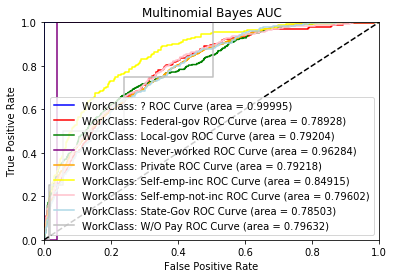

In [139]:
 

import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score

plt.plot(roc_curve(MLR_PRED['?'], mlr_df['prob0'])[0],roc_curve(MLR_PRED['?'], mlr_df['prob0'])[1], 
         color = 'blue', label='WorkClass: ? ROC Curve (area = %0.5f)' % roc_auc_score(MLR_PRED['?'], mlr_df['prob0']))

plt.plot(roc_curve(MLR_PRED['Federal-gov'], mlr_df['prob1'])[0],roc_curve(MLR_PRED['Federal-gov'], mlr_df['prob1'])[1], 
         color = 'red', label='WorkClass: Federal-gov ROC Curve (area = %0.5f)' % roc_auc_score(MLR_PRED['Federal-gov'], mlr_df['prob1']))

plt.plot(roc_curve(MLR_PRED['Local-gov'], mlr_df['prob2'])[0],roc_curve(MLR_PRED['Local-gov'], mlr_df['prob2'])[1], 
         color = 'green', label='WorkClass: Local-gov ROC Curve (area = %0.5f)' % roc_auc_score(MLR_PRED['Local-gov'], mlr_df['prob2']))

plt.plot(roc_curve(MLR_PRED['Never-worked'], mlr_df['prob3'])[0],roc_curve(MLR_PRED['Never-worked'], mlr_df['prob3'])[1], 
         color = 'purple', label='WorkClass: Never-worked ROC Curve (area = %0.5f)' % roc_auc_score(MLR_PRED['Never-worked'], mlr_df['prob3']))

plt.plot(roc_curve(MLR_PRED['Private'], mlr_df['prob4'])[0],roc_curve(MLR_PRED['Private'], mlr_df['prob4'])[1], 
         color = 'orange', label='WorkClass: Private ROC Curve (area = %0.5f)' % roc_auc_score(MLR_PRED['Private'], mlr_df['prob4']))

plt.plot(roc_curve(MLR_PRED['Self-emp-inc'], mlr_df['prob5'])[0],roc_curve(MLR_PRED['Self-emp-inc'], mlr_df['prob5'])[1], 
         color = 'yellow', label='WorkClass: Self-emp-inc ROC Curve (area = %0.5f)' % roc_auc_score(MLR_PRED['Self-emp-inc'], mlr_df['prob5']))

plt.plot(roc_curve(MLR_PRED['Self-emp-not-inc'], mlr_df['prob6'])[0],roc_curve(MLR_PRED['Self-emp-not-inc'], mlr_df['prob6'])[1], 
         color = 'pink', label='WorkClass: Self-emp-not-inc ROC Curve (area = %0.5f)' % roc_auc_score(MLR_PRED['Self-emp-not-inc'], mlr_df['prob6']))

plt.plot(roc_curve(MLR_PRED['State-gov'], mlr_df['prob7'])[0],roc_curve(MLR_PRED['State-gov'], mlr_df['prob7'])[1], 
         color = 'lightblue', label='WorkClass: State-Gov ROC Curve (area = %0.5f)' % roc_auc_score(MLR_PRED['State-gov'], mlr_df['prob7']))

plt.plot(roc_curve(MLR_PRED['Without-pay'], mlr_df['prob8'])[0],roc_curve(MLR_PRED['Without-pay'], mlr_df['prob8'])[1], 
         color = 'silver', label='WorkClass: W/O Pay ROC Curve (area = %0.5f)' % roc_auc_score(MLR_PRED['Without-pay'], mlr_df['prob8']))


plt.plot([0, 2], [0, 2], color='black', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multinomial Bayes AUC')
plt.legend()
plt.show()
sns.set(style='white', rc={'figure.figsize':(10,10)})

# Random Forest Classification

## Using Random Forest to predict income level

In [141]:
from sklearn.ensemble import RandomForestClassifier
tree_df = df1_bern2
tree_df.head()

,Age,WorkClass,fnlwgt,Gender,HoursPerWeek,Income,Educ_ 10th,Educ_ 11th,Educ_ 12th,Educ_ 1st-4th,...,NCountry_ United-States,NCountry_ Vietnam,NCountry_ Yugoslavia,Cap_Gain_1,Cap_Gain_2,Cap_Gain_3,Cap_Loss_1,Cap_Loss_2,Cap_Loss_3,Cap_Loss_4
0,3.663562,State-gov,-788648858049277696,1,40,0,0,0,0,0,...,1,0,0,0,1,0,1,0,0,0
1,3.912023,Self-emp-not-inc,-7166600331323011007,1,13,0,0,0,0,0,...,1,0,0,1,0,0,1,0,0,0
2,3.637586,Private,4278303986812064784,1,40,0,0,0,0,0,...,1,0,0,1,0,0,1,0,0,0
3,3.970292,Private,-8369683455247455359,1,40,0,0,1,0,0,...,1,0,0,1,0,0,1,0,0,0
4,3.332205,Private,-655466583084258015,0,40,0,0,0,0,0,...,0,0,0,1,0,0,1,0,0,0


In [142]:
sum(tree_df['Income'])/len(tree_df['Income'])

0.2408095574460244

In [143]:
onehot_WorkClass = pd.get_dummies(tree_df['WorkClass'], prefix='WorkClass')
tree_df = pd.concat([tree_df, onehot_WorkClass], axis=1)
tree_df= tree_df.drop(['WorkClass'],axis=1)
tree_df.head()

,Age,fnlwgt,Gender,HoursPerWeek,Income,Educ_ 10th,Educ_ 11th,Educ_ 12th,Educ_ 1st-4th,Educ_ 5th-6th,...,Cap_Loss_4,WorkClass_ ?,WorkClass_ Federal-gov,WorkClass_ Local-gov,WorkClass_ Never-worked,WorkClass_ Private,WorkClass_ Self-emp-inc,WorkClass_ Self-emp-not-inc,WorkClass_ State-gov,WorkClass_ Without-pay
0,3.663562,-788648858049277696,1,40,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
1,3.912023,-7166600331323011007,1,13,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
2,3.637586,4278303986812064784,1,40,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
3,3.970292,-8369683455247455359,1,40,0,0,1,0,0,0,...,0,0,0,0,0,1,0,0,0,0
4,3.332205,-655466583084258015,0,40,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0


In [144]:
#Split into features and target

TREEtures = tree_df.drop(['Income'],axis=1)
target_rf = tree_df[['Income']]

In [145]:
#train test split

X_train, X_test, y_train, y_test = train_test_split(TREEtures, 
                                                    target_rf, 
                                                    test_size=0.2, 
                                                    random_state=1)

## First, let's construct an RF model using the default hyperparameters

In [146]:
from sklearn.metrics import roc_curve, auc
from sklearn.ensemble import RandomForestClassifier

rf_default = RandomForestClassifier(random_state=1,n_jobs=-1)
rf_default.fit(X_train, y_train)
pred_train_default = rf_default.predict(X_train)

In [147]:
print(classification_report(y_train, pred_train_default))

              precision    recall  f1-score   support

           0       0.98      1.00      0.99     19694
           1       0.99      0.95      0.97      6354

    accuracy                           0.99     26048
   macro avg       0.99      0.97      0.98     26048
weighted avg       0.99      0.99      0.99     26048



In [148]:
pred_default = rf_default.predict(X_test) 
print(classification_report(y_test, pred_default))

              precision    recall  f1-score   support

           0       0.87      0.92      0.89      5026
           1       0.66      0.55      0.60      1487

    accuracy                           0.83      6513
   macro avg       0.77      0.73      0.75      6513
weighted avg       0.83      0.83      0.83      6513



## Uh oh! These metrics indicate that the model is very overfit to the training data.

## Let's do a little hyperparameter tuning. 

In [149]:
# Run model with hyperparameters set values that just "seem" good, based on little to no
# actual reasoning. 

rf = RandomForestClassifier(random_state = 1, 
                            n_jobs = -1, 
                            n_estimators = 10,
                            criterion = 'gini', 
                            max_features = 5, 
                            max_depth = 11,
                            min_samples_split = 0.1,
                            min_samples_leaf = 0.2,
                            min_impurity_decrease = 0.0)

rf.fit(X_train, y_train)
pred_rf = rf.predict(X_test)
print(classification_report(y_test, pred_default))

              precision    recall  f1-score   support

           0       0.87      0.92      0.89      5026
           1       0.66      0.55      0.60      1487

    accuracy                           0.83      6513
   macro avg       0.77      0.73      0.75      6513
weighted avg       0.83      0.83      0.83      6513



In [150]:
#Use gridsearch to more effectively tune the hyperparameters and improve model performance.

from sklearn.model_selection import GridSearchCV 
  
# defining parameter range 
param_grid = {'n_estimators': [1, 5, 20, 50, 100, 150],   
              'max_depth': [1, 5, 10, 15],
              'min_samples_split': [0.1, 0.5, 1.0, 2],
              'min_samples_leaf': [0.1, 0.3, 0.5, 1, 2]
              }  
  
grid = GridSearchCV(rf, 
                    param_grid, 
                    refit = True,
                    n_jobs = -1,
                    verbose = 0) 
  
# fitting the model using gridsearch hyperparameters
grid.fit(X_train, y_train) 

GridSearchCV(cv='warn', error_score='raise-deprecating',
             estimator=RandomForestClassifier(bootstrap=True, class_weight=None,
                                              criterion='gini', max_depth=11,
                                              max_features=5,
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=0.2,
                                              min_samples_split=0.1,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=10, n_jobs=-1,
                                              oob_score=False, random_state=1,
                                              verbose=0, warm_start=False),
             iid='warn', n_jobs=-1,
             param_grid={'max_dep

In [151]:
print(grid.best_params_)
print(grid.best_estimator_)

{'max_depth': 15, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=15, max_features=5, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=-1, oob_score=False, random_state=1, verbose=0,
                       warm_start=False)


In [152]:
grid_pred = grid.predict(X_train)
print(classification_report(y_train, grid_pred))

              precision    recall  f1-score   support

           0       0.87      0.96      0.92     19694
           1       0.84      0.56      0.67      6354

    accuracy                           0.87     26048
   macro avg       0.85      0.76      0.79     26048
weighted avg       0.86      0.87      0.86     26048



In [153]:
grid_pred = grid.predict(X_test)
print(classification_report(y_test, grid_pred))

              precision    recall  f1-score   support

           0       0.87      0.95      0.90      5026
           1       0.74      0.51      0.60      1487

    accuracy                           0.85      6513
   macro avg       0.80      0.73      0.75      6513
weighted avg       0.84      0.85      0.84      6513



## Model performance! After tuning hyperparameters such as n_estimators and max_depth (which, respectively, adjust the number of trees in the forest and the maximum depth of the trees), the model no longer is severely overfit to the training data, and its accuracy has improved from .83 to .85. Nice. 